In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

from numpy import mean
from numpy import std

In [2]:
train_data = pd.read_csv(r"C:\Users\adity\Downloads\train_data.csv")

In [3]:
df=train_data
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
label_count = df["label"].value_counts()
label_count

1    10413
0    10387
Name: label, dtype: int64

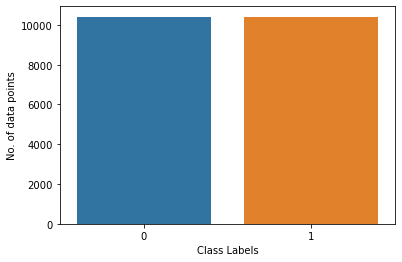

In [6]:
sns.barplot(x=label_count.index, y=label_count.values); # since both label counts are almost same
                                                        # there is no class imbalance.
plt.xlabel("Class Labels")
plt.ylabel("No. of data points")
plt.show()

Dealing with the missing values in the dataframe

In [7]:
# counting the number of missing values in the dataset,
# it counts the number of missing values in each column
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
df[df.title.isnull() & df.author.isnull()] #no rows contain null values simultaniously in author 
                                           #and title column.

Empty DataFrame
Columns: [id, title, author, text, label]
Index: []

In [9]:
# replacing the null values with empty string
df = df.fillna('')
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

**LABEL ENCODING**

In [10]:
len(df['author'].unique())

4202

In [11]:
lst=[]
for author in df.author.unique().tolist():
    new_df=df[df.author==author]
    if len(new_df[new_df.label==0])!=0 and len(new_df[new_df.label==1])!=0:
        lst.append(author)

In [12]:
lst

['', 'Pam Key', 'Pamela Geller', 'Ann Coulter', 'AFP', 'Reuters']

In [13]:
len(lst)

6

In [14]:
#out of 4202 unique authors only  6 have turn out both fake and true news .Hence since most of authors turn out either
#fake or real news they are reliable for vectorisation.

# **STEMMING + Stopwords Removal**

In [15]:
from nltk.corpus import stopwords
nltk.download('stopwords')  #downloading the stopwords from natural Language Toolkit

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1129)>


False

In [16]:
from nltk.stem.porter import PorterStemmer
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',str(content))
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [PorterStemmer().stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [17]:
df['stemm_content']= df['author'] +' '+ df['title']
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                       stemm_content  
0  Darrell Lucus House Dem Aide: We Didn’t Even S...  
1  Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...  
2  Consortiumnews.com Why the Truth Might Get You...  
3  Jessica Purkiss 15 Civilians Killed In Single ...  
4  Howard Portnoy Iranian woman jailed for fictio...

In [18]:
df['stemm_content'] =df['stemm_content'].apply(stemming)

In [19]:
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                       stemm_content  
0  darrel lucu hous dem aid even see comey letter...  
1  daniel j flynn flynn hillari clinton big woman...  
2             consortiumnew com truth might get fire  
3  jessica purkiss civilian kill singl us airstri...  
4  howard portnoy iranian woman jail fiction unpu...

# **LEMMATIZATION + Stopwords Removal**

In [20]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
def cleaning_lemmetize(content):
    document = re.sub('[^a-zA-Z]',' ',str(content))
    document = document.lower()
    document = document.split()
    document = [WordNetLemmatizer().lemmatize(word) for word in document if not word in stopwords.words('english')]
    document = ' '.join(document)
    return document

In [21]:
df['lemm_content']=(df['author']+' '+df['title']).apply(cleaning_lemmetize)
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                       stemm_content  \
0  darrel lucu hous dem aid even see comey letter...   
1  daniel j flynn flynn hillari clinton big woman...   
2             consortiumnew com truth might get fire   
3  jessica purkiss civilian kill singl us airstri...   
4  howard portnoy iranian woman jail fiction unpu...   

                                        lemm_content  
0  darrell lucus house dem aide even see comey le...  
1  daniel j flynn flynn hillary clinton big woman...  
2           consortiumnews com truth might get fired  
3  jessica purkiss civilian killed single u airst...  
4  howard portnoy iranian woman jailed fictional ...

In [22]:
Y = df['label'].values

# **BAG-OF-WORDS**

In [23]:
BOW_vectorizer = CountVectorizer()
X_stemm_bow = BOW_vectorizer.fit_transform(df['stemm_content'].values)

In [24]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_stemm_bow, Y, test_size = 0.3)

In [25]:
X_stemm_bow

<20800x17128 sparse matrix of type '<class 'numpy.int64'>'
	with 210687 stored elements in Compressed Sparse Row format>

**Logistic Regression**

In [26]:
log_reg1=LogisticRegression()
log_reg1.fit(X_train1,Y_train1)

Y_lr_train_pred1 =log_reg1.predict(X_train1)
Y_lr_test_pred1 =log_reg1.predict(X_test1)

In [27]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_lr_train_pred1))

print(f"The accuracy score for train data is {accuracy_score(Y_train1,Y_lr_train_pred1)}")

print('The classification report is:')
print(classification_report(Y_train1,Y_lr_train_pred1))
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train1,Y_lr_train_pred1)

the confusion matrix for train data is:
[[7266    8]
 [  10 7276]]
The accuracy score for train data is 0.9987637362637363
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7274
           1       1.00      1.00      1.00      7286

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [28]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_lr_test_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_test1,Y_lr_test_pred1)}")

print('The classification report is:')
print(classification_report(Y_test1,Y_lr_test_pred1))
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test1,Y_lr_test_pred1)

the confusion matrix for test data is:
[[3062   51]
 [  19 3108]]
the accuracy score for train data is 0.9887820512820513
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3113
           1       0.98      0.99      0.99      3127

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Decision Tree**

In [29]:
my_dt1 = DecisionTreeClassifier()
my_dt1.fit(X_train1,Y_train1)

Y_dt_train_pred1 =my_dt1.predict(X_train1)
Y_dt_test_pred1 =my_dt1.predict(X_test1)

In [30]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_dt_train_pred1))

print(f"The accuracy score for train data is {accuracy_score(Y_train1,Y_dt_train_pred1)}")
dict_train['DecisionTree']=accuracy_score(Y_train1,Y_dt_train_pred1)
print('The classification report is:')
print(classification_report(Y_train1,Y_dt_train_pred1))

the confusion matrix for train data is:
[[7274    0]
 [   0 7286]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7274
           1       1.00      1.00      1.00      7286

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [31]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_dt_test_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_test1,Y_dt_test_pred1)}")
dict_test['DecisionTree']=accuracy_score(Y_test1,Y_dt_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_dt_test_pred1))

the confusion matrix for test data is:
[[3095   18]
 [  20 3107]]
the accuracy score for train data is 0.9939102564102564
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3113
           1       0.99      0.99      0.99      3127

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Random Forest Classifier**

In [32]:
my_rf1 = RandomForestClassifier()
my_rf1.fit(X_train1,Y_train1)

Y_rf_train_pred1 =my_rf1.predict(X_train1)
Y_rf_test_pred1 =my_rf1.predict(X_test1)

In [33]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_rf_train_pred1))

print(f"The accuracy score for train data is {accuracy_score(Y_train1,Y_rf_train_pred1)}")
dict_train['RandomForest']=accuracy_score(Y_train1,Y_rf_train_pred1)
print('The classification report is:')
print(classification_report(Y_train1,Y_rf_train_pred1))

the confusion matrix for train data is:
[[7274    0]
 [   0 7286]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7274
           1       1.00      1.00      1.00      7286

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [34]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_rf_test_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_test1,Y_rf_test_pred1)}")
dict_test['RandomForest']=accuracy_score(Y_test1,Y_rf_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_rf_test_pred1))

the confusion matrix for test data is:
[[3075   38]
 [  14 3113]]
the accuracy score for train data is 0.9916666666666667
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3113
           1       0.99      1.00      0.99      3127

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Multinomial Naive Bayes Classifier**

In [35]:
my_nbc1 = MultinomialNB()
my_nbc1= my_nbc1.fit(X_train1,Y_train1)

Y_nbc_train_pred1 = my_nbc1.predict(X_train1)
Y_nbc_test_pred1 = my_nbc1.predict(X_test1)

In [36]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_nbc_train_pred1))

print(f"The accuracy score for train data is {accuracy_score(Y_train1,Y_nbc_train_pred1)}")
dict_train['MultinomialNB']=accuracy_score(Y_train1,Y_nbc_train_pred1)
print('The classification report is:')
print(classification_report(Y_train1,Y_nbc_train_pred1))

the confusion matrix for train data is:
[[7253   21]
 [ 241 7045]]
The accuracy score for train data is 0.9820054945054945
The classification report is:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      7274
           1       1.00      0.97      0.98      7286

    accuracy                           0.98     14560
   macro avg       0.98      0.98      0.98     14560
weighted avg       0.98      0.98      0.98     14560



In [37]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_nbc_test_pred1))

print(f"the accuracy score for test data is {accuracy_score(Y_test1,Y_nbc_test_pred1)}")
dict_test['MultinomialNB']=accuracy_score(Y_test1,Y_nbc_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_nbc_test_pred1))

the confusion matrix for test data is:
[[3094   19]
 [ 221 2906]]
the accuracy score for test data is 0.9615384615384616
The classification report is:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3113
           1       0.99      0.93      0.96      3127

    accuracy                           0.96      6240
   macro avg       0.96      0.96      0.96      6240
weighted avg       0.96      0.96      0.96      6240



**K-Nearest Neighbour**

In [38]:
param_grid_knn1 = {"n_neighbors": [3,5,7,9,11,13,15]}

knn1 = KNeighborsClassifier()

grid_knn1= GridSearchCV(estimator=knn1,param_grid=param_grid_knn1,scoring="accuracy",verbose=1)

grid_knn1 = grid_knn1.fit(X_train1,Y_train1)

print(grid_knn1.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 3}


In [39]:
my_knn1 = KNeighborsClassifier(n_neighbors=3)
my_knn1 = my_knn1.fit(X_train1,Y_train1)

Y_knn_train_pred1 = my_knn1.predict(X_train1)
Y_knn_test_pred1 = my_knn1.predict(X_test1)

In [40]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_knn_train_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_train1,Y_knn_train_pred1)}")
dict_train['KNN']=accuracy_score(Y_train1,Y_knn_train_pred1)
print('The classification report is:')
print(classification_report(Y_train1,Y_knn_train_pred1))

the confusion matrix for train data is:
[[5273 2001]
 [   6 7280]]
the accuracy score for train data is 0.8621565934065935
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      7274
           1       0.78      1.00      0.88      7286

    accuracy                           0.86     14560
   macro avg       0.89      0.86      0.86     14560
weighted avg       0.89      0.86      0.86     14560



In [41]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_knn_test_pred1))

print(f"the accuracy score for test data is: {accuracy_score(Y_test1,Y_knn_test_pred1)}")
dict_test['KNN']=accuracy_score(Y_test1,Y_knn_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_knn_test_pred1))

the confusion matrix for test data is:
[[2017 1096]
 [   6 3121]]
the accuracy score for test data is: 0.8233974358974359
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      3113
           1       0.74      1.00      0.85      3127

    accuracy                           0.82      6240
   macro avg       0.87      0.82      0.82      6240
weighted avg       0.87      0.82      0.82      6240



**SVC**

In [42]:
param_grid_svm1 = {"kernel": ['linear','rbf','poly','sigmoid']}

svm1 = SVC()

grid_svm1= GridSearchCV(estimator=svm1,param_grid=param_grid_svm1,scoring="accuracy",verbose=1)

grid_svm1 = grid_svm1.fit(X_train1,Y_train1)

print(grid_svm1.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'linear'}


In [43]:
my_svm1 = SVC( kernel='linear')
my_svm1 = my_svm1.fit(X_train1,Y_train1)

Y_svm_train_pred1 = my_svm1.predict(X_train1)
Y_svm_test_pred1 = my_svm1.predict(X_test1)

In [44]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_svm_train_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_train1,Y_svm_train_pred1)}")
dict_train['SVC']=accuracy_score(Y_train1,Y_svm_train_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_svm_test_pred1))

the confusion matrix for train data is:
[[7274    0]
 [   0 7286]]
the accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3113
           1       0.99      0.99      0.99      3127

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



In [45]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_svm_test_pred1))

print(f"the accuracy score for test data is: {accuracy_score(Y_test1,Y_svm_test_pred1)}")
dict_test['SVC']=accuracy_score(Y_test1,Y_svm_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_svm_test_pred1))

the confusion matrix for test data is:
[[3088   25]
 [  20 3107]]
the accuracy score for test data is: 0.9927884615384616
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3113
           1       0.99      0.99      0.99      3127

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Plotting accuracy of models**

test accuracy {'LogisticRegression': 0.9887820512820513, 'DecisionTree': 0.9939102564102564, 'RandomForest': 0.9916666666666667, 'MultinomialNB': 0.9615384615384616, 'KNN': 0.8233974358974359, 'SVC': 0.9927884615384616}
train accuracy {'LogisticRegression': 0.9987637362637363, 'DecisionTree': 1.0, 'RandomForest': 1.0, 'MultinomialNB': 0.9820054945054945, 'KNN': 0.8621565934065935, 'SVC': 1.0}


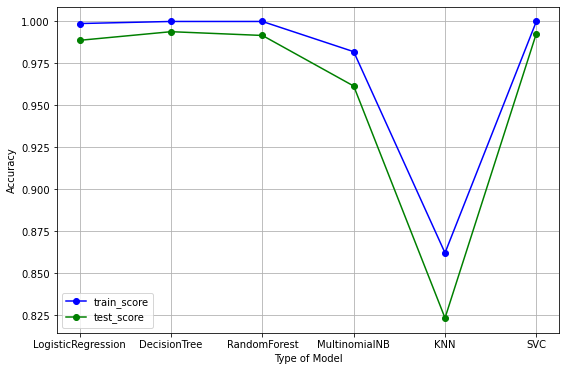

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')
print('test accuracy',dict_test)
print('train accuracy',dict_train)

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [47]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('MultinomialNB', MultinomialNB( )))

models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVC', SVC(kernel='linear')))
seed = 7
# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_stemm_bow, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LogisticRegression: 0.990577 (0.001776)
DecisionTreeClassifier: 0.994856 (0.002085)
RandomForestClassifier: 0.994231 (0.002005)
MultinomialNB: 0.963558 (0.004724)
KNN: 0.834615 (0.009213)
SVC: 0.994904 (0.001749)


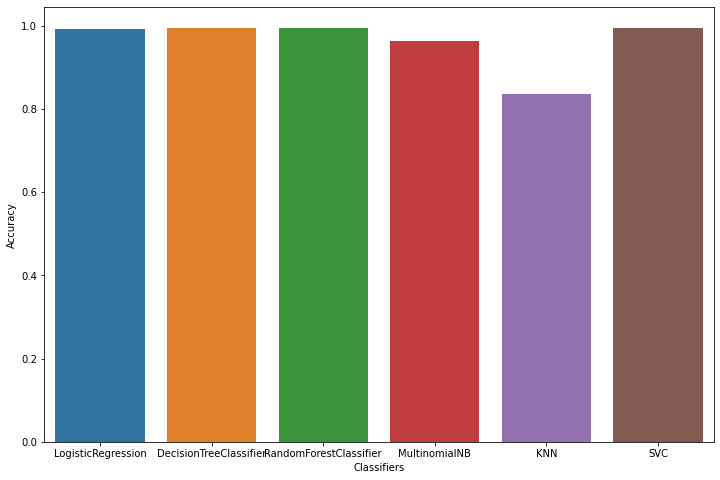

In [48]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Decision Tree Classifier and SVC**

In [49]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = DecisionTreeClassifier()


# evaluate model 2
model2 = SVC(kernel='linear')

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.7482502421160744 t-Statistic: -0.3391877360614926
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.


# **BAG-OF WORDS + CHI SQUARED TEST**

In [50]:
X_names1 = BOW_vectorizer.get_feature_names()

C:\Users\adity\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [51]:
chi2, p = chi2(X_stemm_bow, Y)

In [52]:
data1={'features':X_names1,'score':p}
df_features1=pd.DataFrame(data1)

In [53]:
alpha=.05

In [54]:
df_features_new1=df_features1[df_features1.score<alpha]
df_features_new1

features         score
5        aaron  7.437698e-08
13        abbi  1.587905e-03
24         abe  2.247902e-03
26      abedin  5.599195e-07
28     abelson  6.201666e-05
...        ...           ...
17089  zionist  6.469340e-05
17095    zombi  4.577073e-02
17102   zraick  3.117645e-13
17104       zu  9.247221e-04
17112    zuess  2.805669e-06

[3036 rows x 2 columns]

In [55]:
X_names_new1=list(df_features_new1.features.values)
X_names_new1

['aaron',
 'abbi',
 'abe',
 'abedin',
 'abelson',
 'aboard',
 'abort',
 'abram',
 'abroad',
 'abus',
 'access',
 'accur',
 'acknowledg',
 'acosta',
 'acquit',
 'activist',
 'activistpost',
 'actual',
 'acuesta',
 'adam',
 'add',
 'adebayo',
 'adel',
 'adelmann',
 'adhd',
 'adl',
 'adler',
 'admin',
 'administr',
 'admit',
 'adpr',
 'advert',
 'advic',
 'advis',
 'afghan',
 'agorist',
 'agre',
 'agreement',
 'ahca',
 'ahm',
 'ahmad',
 'ahtribun',
 'ail',
 'aim',
 'airbag',
 'airlin',
 'airstrik',
 'aker',
 'akihito',
 'al',
 'aladdinsmiraclelamp',
 'alan',
 'alaska',
 'albrecht',
 'alcindor',
 'alderman',
 'aleppo',
 'alert',
 'alessandra',
 'alex',
 'alexa',
 'alexandra',
 'alfano',
 'ali',
 'alisha',
 'alison',
 'alissa',
 'all',
 'allan',
 'allegedli',
 'alli',
 'allison',
 'allum',
 'almost',
 'alphabet',
 'alreadi',
 'alt',
 'alter',
 'altern',
 'altruist',
 'alvarez',
 'amando',
 'amaz',
 'amazon',
 'ambella',
 'ambit',
 'america',
 'american',
 'amid',
 'ammo',
 'ammon',
 'ampt',

In [56]:
vectorizer1 = CountVectorizer(vocabulary=X_names_new1)
vectorizer1.fit(df['stemm_content'].values)
X_stemm_bow_chi = vectorizer1.transform(df['stemm_content'].values)  #USEFUL

In [57]:
X_stemm_bow_chi

<20800x3036 sparse matrix of type '<class 'numpy.int64'>'
	with 129947 stored elements in Compressed Sparse Row format>

In [58]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_stemm_bow_chi, Y, test_size = 0.3)

**Logistic Regression**

In [59]:
log_reg2=LogisticRegression()
log_reg2.fit(X_train2,Y_train2)

Y_lr_train_pred2 =log_reg2.predict(X_train2)
Y_lr_test_pred2 =log_reg2.predict(X_test2)

In [60]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_lr_train_pred2))

print(f"The accuracy score for train data is {accuracy_score(Y_train2,Y_lr_train_pred2)}")

print('The classification report is:')
print(classification_report(Y_train2,Y_lr_train_pred2))
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train2,Y_lr_train_pred2)

the confusion matrix for train data is:
[[7199   41]
 [  26 7294]]
The accuracy score for train data is 0.9953983516483517
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7240
           1       0.99      1.00      1.00      7320

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [61]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_lr_test_pred2))

print(f"the accuracy score for train data is {accuracy_score(Y_test2,Y_lr_test_pred2)}")

print('The classification report is:')
print(classification_report(Y_test2,Y_lr_test_pred2))
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test2,Y_lr_test_pred2)

the confusion matrix for test data is:
[[3097   50]
 [  13 3080]]
the accuracy score for train data is 0.9899038461538462
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3147
           1       0.98      1.00      0.99      3093

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Decision Tree**

In [62]:
my_dt2 = DecisionTreeClassifier()
my_dt2.fit(X_train2,Y_train2)

Y_dt_train_pred2 =my_dt2.predict(X_train2)
Y_dt_test_pred2 =my_dt2.predict(X_test2)

In [63]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_dt_train_pred2))

print(f"The accuracy score for train data is {accuracy_score(Y_train2,Y_dt_train_pred2)}")
dict_train['DecisionTree']=accuracy_score(Y_train2,Y_dt_train_pred2)

print('The classification report is:')
print(classification_report(Y_train2,Y_dt_train_pred2))

the confusion matrix for train data is:
[[7240    0]
 [   0 7320]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7240
           1       1.00      1.00      1.00      7320

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [64]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_dt_test_pred2))

print(f"the accuracy score for train data is {accuracy_score(Y_test2,Y_dt_test_pred2)}")
dict_test['DecisionTree']=accuracy_score(Y_test2,Y_dt_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_dt_test_pred2))

the confusion matrix for test data is:
[[3128   19]
 [  26 3067]]
the accuracy score for train data is 0.9927884615384616
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3147
           1       0.99      0.99      0.99      3093

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Random Forest Classifier**

In [65]:
my_rf2 = RandomForestClassifier()
my_rf2.fit(X_train2,Y_train2)

Y_rf_train_pred2 =my_rf2.predict(X_train2)
Y_rf_test_pred2 =my_rf2.predict(X_test2)

In [66]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_rf_train_pred2))

print(f"The accuracy score for train data is {accuracy_score(Y_train2,Y_rf_train_pred2)}")
dict_train['RandomForest']=accuracy_score(Y_train2,Y_rf_train_pred2)

print('The classification report is:')
print(classification_report(Y_train2,Y_rf_train_pred2))

the confusion matrix for train data is:
[[7240    0]
 [   0 7320]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7240
           1       1.00      1.00      1.00      7320

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [67]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_rf_test_pred2))

print(f"the accuracy score for test data is {accuracy_score(Y_test2,Y_rf_test_pred2)}")
dict_test['RandomForest']=accuracy_score(Y_test2,Y_rf_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_rf_test_pred2))

the confusion matrix for test data is:
[[3111   36]
 [   9 3084]]
the accuracy score for test data is 0.9927884615384616
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3147
           1       0.99      1.00      0.99      3093

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Multinomial Naive Bayes Classifier**

In [68]:
my_nbc2 = MultinomialNB()
my_nbc2= my_nbc2.fit(X_train2,Y_train2)

Y_nbc_train_pred2 = my_nbc2.predict(X_train2)
Y_nbc_test_pred2 = my_nbc2.predict(X_test2)

In [69]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_nbc_train_pred2))

print(f"The accuracy score for train data is {accuracy_score(Y_train2,Y_nbc_train_pred2)}")
dict_train['MultinomialNB']=accuracy_score(Y_train2,Y_nbc_train_pred2)
print('The classification report is:')
print(classification_report(Y_train2,Y_nbc_train_pred2))

the confusion matrix for train data is:
[[7208   32]
 [ 395 6925]]
The accuracy score for train data is 0.9706730769230769
The classification report is:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7240
           1       1.00      0.95      0.97      7320

    accuracy                           0.97     14560
   macro avg       0.97      0.97      0.97     14560
weighted avg       0.97      0.97      0.97     14560



In [70]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_nbc_test_pred2))

print(f"the accuracy score for test data is {accuracy_score(Y_test2,Y_nbc_test_pred2)}")
dict_test['MultinomialNB']=accuracy_score(Y_test2,Y_nbc_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_nbc_test_pred2))

the confusion matrix for test data is:
[[3127   20]
 [ 182 2911]]
the accuracy score for test data is 0.9676282051282051
The classification report is:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3147
           1       0.99      0.94      0.97      3093

    accuracy                           0.97      6240
   macro avg       0.97      0.97      0.97      6240
weighted avg       0.97      0.97      0.97      6240



**K-Nearest Neighbour**

In [71]:
param_grid_knn2 = {"n_neighbors": [3,5,7,9,11,13,15]}

knn2 = KNeighborsClassifier()

grid_knn2= GridSearchCV(estimator=knn2,param_grid=param_grid_knn2,scoring="accuracy",verbose=1)

grid_knn2 = grid_knn2.fit(X_train2,Y_train2)

print(grid_knn2.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 3}


In [72]:
my_knn2 = KNeighborsClassifier(n_neighbors=3)
my_knn2 = my_knn2.fit(X_train2,Y_train2)

Y_knn_train_pred2 = my_knn2.predict(X_train2)
Y_knn_test_pred2 = my_knn2.predict(X_test2)

In [73]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_knn_train_pred2))

print(f"the accuracy score for train data is {accuracy_score(Y_train2,Y_knn_train_pred2)}")
dict_train['KNN']=accuracy_score(Y_train2,Y_knn_train_pred2)
print('The classification report is:')
print(classification_report(Y_train2,Y_knn_train_pred2))

the confusion matrix for train data is:
[[6999  241]
 [  22 7298]]
the accuracy score for train data is 0.9819368131868131
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      7240
           1       0.97      1.00      0.98      7320

    accuracy                           0.98     14560
   macro avg       0.98      0.98      0.98     14560
weighted avg       0.98      0.98      0.98     14560



In [74]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_knn_test_pred2))

print(f"the accuracy score for test data is: {accuracy_score(Y_test2,Y_knn_test_pred2)}")
dict_test['KNN']=accuracy_score(Y_test2,Y_knn_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_knn_test_pred2))

the confusion matrix for test data is:
[[2943  204]
 [   6 3087]]
the accuracy score for test data is: 0.9663461538461539
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      3147
           1       0.94      1.00      0.97      3093

    accuracy                           0.97      6240
   macro avg       0.97      0.97      0.97      6240
weighted avg       0.97      0.97      0.97      6240



**SVC**

In [75]:
param_grid_svm2 = {"kernel": ['linear','rbf','poly','sigmoid']}

svm2 = SVC()

grid_svm2= GridSearchCV(estimator=svm2,param_grid=param_grid_svm2,scoring="accuracy",verbose=1)

grid_svm2 = grid_svm2.fit(X_train2,Y_train2)

print(grid_svm2.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'linear'}


In [76]:
my_svm2 = SVC( kernel='linear')
my_svm2 = my_svm2.fit(X_train2,Y_train2)

Y_svm_train_pred2 = my_svm2.predict(X_train2)
Y_svm_test_pred2 = my_svm2.predict(X_test2)

In [77]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_svm_train_pred2))

print(f"the accuracy score for train data is {accuracy_score(Y_train2,Y_svm_train_pred2)}")
dict_train['SVC']=accuracy_score(Y_train2,Y_svm_train_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_svm_test_pred2))

the confusion matrix for train data is:
[[7227   13]
 [  12 7308]]
the accuracy score for train data is 0.998282967032967
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3147
           1       0.99      1.00      0.99      3093

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



In [78]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_svm_test_pred2))

print(f"the accuracy score for test data is: {accuracy_score(Y_test2,Y_svm_test_pred2)}")
dict_test['SVC']=accuracy_score(Y_test2,Y_svm_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_svm_test_pred2))

the confusion matrix for test data is:
[[3123   24]
 [  10 3083]]
the accuracy score for test data is: 0.9945512820512821
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3147
           1       0.99      1.00      0.99      3093

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Plotting accuracy of models**

test accuracy {'LogisticRegression': 0.9899038461538462, 'DecisionTree': 0.9927884615384616, 'RandomForest': 0.9927884615384616, 'MultinomialNB': 0.9676282051282051, 'KNN': 0.9663461538461539, 'SVC': 0.9945512820512821}
train accuracy {'LogisticRegression': 0.9953983516483517, 'DecisionTree': 1.0, 'RandomForest': 1.0, 'MultinomialNB': 0.9706730769230769, 'KNN': 0.9819368131868131, 'SVC': 0.998282967032967}


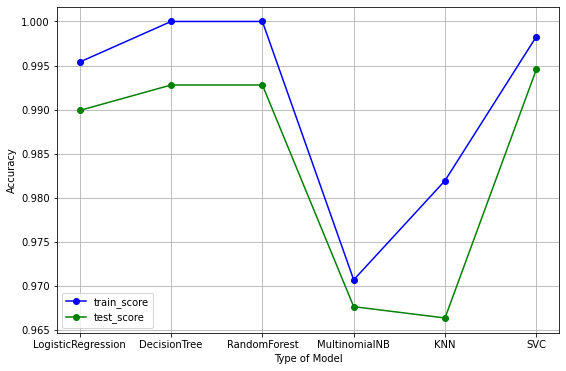

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')
print('test accuracy',dict_test)
print('train accuracy',dict_train)

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [80]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('MultinomialNB', MultinomialNB( )))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVC', SVC(kernel='linear')))
seed = 7

# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_stemm_bow_chi, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LogisticRegression: 0.991538 (0.002257)
DecisionTreeClassifier: 0.993990 (0.001493)
RandomForestClassifier: 0.994183 (0.002045)
MultinomialNB: 0.955529 (0.013441)
KNN: 0.965385 (0.004510)
SVC: 0.995000 (0.002247)


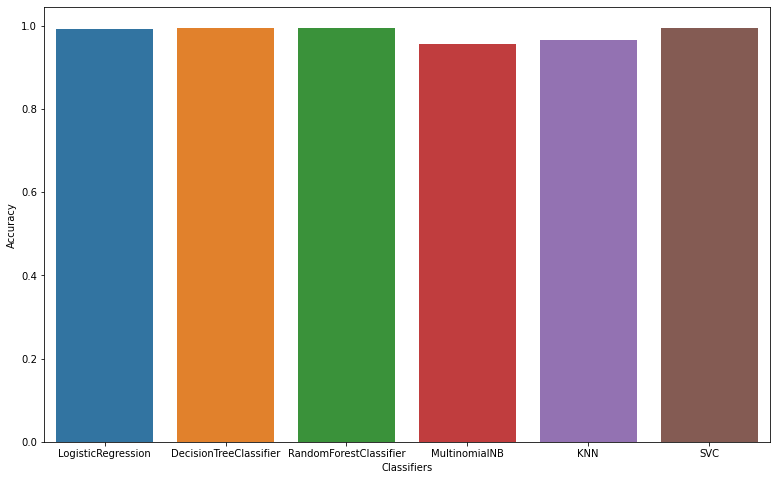

In [81]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Random Forest Classifier and SVC**

In [82]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = RandomForestClassifier()


# evaluate model 2
model2 = SVC()

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.005106312500422365 t-Statistic: 4.749604903177891
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.


# **TF-IDF VECTORIZER**

In [83]:
tfidf1 = TfidfVectorizer()

tfidf1.fit(df["stemm_content"].values)
X_stemm_tfidf = tfidf1.transform(df["stemm_content"].values)    #USEFUL

In [84]:
X_stemm_tfidf

<20800x17128 sparse matrix of type '<class 'numpy.float64'>'
	with 210687 stored elements in Compressed Sparse Row format>

In [85]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X_stemm_tfidf, Y, test_size = 0.3)

**Logistic Regression**

In [86]:
log_reg3=LogisticRegression()
log_reg3.fit(X_train3,Y_train3)

Y_lr_train_pred3 =log_reg3.predict(X_train3)
Y_lr_test_pred3 =log_reg3.predict(X_test3)

In [87]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_lr_train_pred3))

print(f"The accuracy score for train data is {accuracy_score(Y_train3,Y_lr_train_pred3)}")

print('The classification report is:')
print(classification_report(Y_train3,Y_lr_train_pred3))
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train3,Y_lr_train_pred3)

the confusion matrix for train data is:
[[7123  162]
 [  39 7236]]
The accuracy score for train data is 0.986195054945055
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7285
           1       0.98      0.99      0.99      7275

    accuracy                           0.99     14560
   macro avg       0.99      0.99      0.99     14560
weighted avg       0.99      0.99      0.99     14560



In [88]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_lr_test_pred3))

print(f"the accuracy score for train data is {accuracy_score(Y_test3,Y_lr_test_pred3)}")

print('The classification report is:')
print(classification_report(Y_test3,Y_lr_test_pred3))
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test3,Y_lr_test_pred3)

the confusion matrix for test data is:
[[2975  127]
 [  32 3106]]
the accuracy score for train data is 0.9745192307692307
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3102
           1       0.96      0.99      0.98      3138

    accuracy                           0.97      6240
   macro avg       0.98      0.97      0.97      6240
weighted avg       0.97      0.97      0.97      6240



**Decision Tree**

In [89]:
my_dt3 = DecisionTreeClassifier()
my_dt3.fit(X_train3,Y_train3)

Y_dt_train_pred3 =my_dt3.predict(X_train3)
Y_dt_test_pred3 =my_dt3.predict(X_test3)

In [90]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_dt_train_pred3))

print(f"The accuracy score for train data is {accuracy_score(Y_train3,Y_dt_train_pred3)}")
dict_train['DecisionTree']=accuracy_score(Y_train3,Y_dt_train_pred3)
print('The classification report is:')
print(classification_report(Y_train3,Y_dt_train_pred3))

the confusion matrix for train data is:
[[7285    0]
 [   0 7275]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7285
           1       1.00      1.00      1.00      7275

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [91]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_dt_test_pred3))

print(f"the accuracy score for test data is {accuracy_score(Y_test3,Y_dt_test_pred3)}")
dict_test['DecisionTree']=accuracy_score(Y_test3,Y_dt_test_pred3)
print('The classification report is:')
print(classification_report(Y_test3,Y_dt_test_pred3))

the confusion matrix for test data is:
[[3084   18]
 [  28 3110]]
the accuracy score for test data is 0.9926282051282052
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3102
           1       0.99      0.99      0.99      3138

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Random Forest Classifier**

In [92]:
my_rf3 = RandomForestClassifier()
my_rf3.fit(X_train3,Y_train3)

Y_rf_train_pred3 =my_rf3.predict(X_train3)
Y_rf_test_pred3 =my_rf3.predict(X_test3)

In [93]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_rf_train_pred3))

print(f"The accuracy score for train data is {accuracy_score(Y_train3,Y_rf_train_pred3)}")
dict_train['RandomForest']=accuracy_score(Y_train3,Y_rf_train_pred3)

print('The classification report is:')
print(classification_report(Y_train3,Y_rf_train_pred3))

the confusion matrix for train data is:
[[7285    0]
 [   0 7275]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7285
           1       1.00      1.00      1.00      7275

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [94]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_rf_test_pred3))

print(f"the accuracy score for test data is {accuracy_score(Y_test3,Y_rf_test_pred3)}")
dict_test['RandomForest']=accuracy_score(Y_test3,Y_rf_test_pred3)

print('The classification report is:')
print(classification_report(Y_test3,Y_rf_test_pred3))

the confusion matrix for test data is:
[[3065   37]
 [  12 3126]]
the accuracy score for test data is 0.9921474358974359
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3102
           1       0.99      1.00      0.99      3138

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Multinomial Naive Bayes Classifier**

In [95]:
my_nbc3= MultinomialNB()
my_nbc3= my_nbc3.fit(X_train3,Y_train3)

Y_nbc_train_pred3 = my_nbc3.predict(X_train3)
Y_nbc_test_pred3 = my_nbc3.predict(X_test3)

In [96]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_nbc_train_pred3))

print(f"The accuracy score for train data is {accuracy_score(Y_train3,Y_nbc_train_pred3)}")
dict_train['MultinomialNB']=accuracy_score(Y_train3,Y_nbc_train_pred3)

print('The classification report is:')
print(classification_report(Y_train3,Y_nbc_train_pred3))

the confusion matrix for train data is:
[[7271   14]
 [ 386 6889]]
The accuracy score for train data is 0.9725274725274725
The classification report is:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7285
           1       1.00      0.95      0.97      7275

    accuracy                           0.97     14560
   macro avg       0.97      0.97      0.97     14560
weighted avg       0.97      0.97      0.97     14560



In [97]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_nbc_test_pred3))

print(f"the accuracy score for test data is {accuracy_score(Y_test3,Y_nbc_test_pred3)}")
dict_test['MultinomialNB']=accuracy_score(Y_test3,Y_nbc_test_pred3)

print('The classification report is:')
print(classification_report(Y_test3,Y_nbc_test_pred3))

the confusion matrix for test data is:
[[3092   10]
 [ 306 2832]]
the accuracy score for test data is 0.9493589743589743
The classification report is:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3102
           1       1.00      0.90      0.95      3138

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240



**K-Nearest Neighbour**

In [98]:
param_grid_knn3 = {"n_neighbors": [3,5,7,9,11,13,15]}

knn3 = KNeighborsClassifier()

grid_knn3= GridSearchCV(estimator=knn3,param_grid=param_grid_knn3,scoring="accuracy",verbose=1)

grid_knn3 = grid_knn3.fit(X_train3,Y_train3)

print(grid_knn3.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 3}


In [99]:
my_knn3 = KNeighborsClassifier(n_neighbors=3)
my_knn3 = my_knn3.fit(X_train3,Y_train3)

Y_knn_train_pred3 = my_knn3.predict(X_train3)
Y_knn_test_pred3 = my_knn3.predict(X_test3)

In [100]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_knn_train_pred3))

print(f"the accuracy score for train data is {accuracy_score(Y_train3,Y_knn_train_pred3)}")
dict_train['KNN']=accuracy_score(Y_train3,Y_knn_train_pred3)
print('The classification report is:')
print(classification_report(Y_train3,Y_knn_train_pred3))

the confusion matrix for train data is:
[[1156 6129]
 [   2 7273]]
the accuracy score for train data is 0.5789148351648352
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.16      0.27      7285
           1       0.54      1.00      0.70      7275

    accuracy                           0.58     14560
   macro avg       0.77      0.58      0.49     14560
weighted avg       0.77      0.58      0.49     14560



In [101]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_knn_test_pred3))

print(f"the accuracy score for test data is: {accuracy_score(Y_test3,Y_knn_test_pred3)}")
dict_test['KNN']=accuracy_score(Y_test3,Y_knn_test_pred3)
print('The classification report is:')
print(classification_report(Y_test3,Y_knn_test_pred3))

the confusion matrix for test data is:
[[ 214 2888]
 [   0 3138]]
the accuracy score for test data is: 0.5371794871794872
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.07      0.13      3102
           1       0.52      1.00      0.68      3138

    accuracy                           0.54      6240
   macro avg       0.76      0.53      0.41      6240
weighted avg       0.76      0.54      0.41      6240



**SVC**

In [102]:
param_grid_svm3= {"kernel": ['linear','rbf','poly','sigmoid']}

svm3 = SVC()

grid_svm3= GridSearchCV(estimator=svm3,param_grid=param_grid_svm3,scoring="accuracy",verbose=1)

grid_svm3 = grid_svm3.fit(X_train3,Y_train3)

print(grid_svm3.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'linear'}


In [103]:
my_svm3 = SVC( kernel='linear')
my_svm3= my_svm3.fit(X_train3,Y_train3)

Y_svm_train_pred3 = my_svm3.predict(X_train3)
Y_svm_test_pred3 = my_svm3.predict(X_test3)

In [104]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_svm_train_pred3))

print(f"the accuracy score for train data is {accuracy_score(Y_train3,Y_svm_train_pred3)}")
dict_train['SVC']=accuracy_score(Y_train3,Y_svm_train_pred3)
print('The classification report is:')
print(classification_report(Y_test3,Y_svm_test_pred3))

the confusion matrix for train data is:
[[7269   16]
 [  21 7254]]
the accuracy score for train data is 0.9974587912087912
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3102
           1       0.99      0.99      0.99      3138

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



In [105]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_svm_test_pred3))

print(f"the accuracy score for test data is: {accuracy_score(Y_test3,Y_svm_test_pred3)}")
dict_test['SVC']=accuracy_score(Y_test3,Y_svm_test_pred3)
print('The classification report is:')
print(classification_report(Y_test3,Y_svm_test_pred3))

the confusion matrix for test data is:
[[3067   35]
 [  25 3113]]
the accuracy score for test data is: 0.9903846153846154
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3102
           1       0.99      0.99      0.99      3138

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Plotting acurracy of the models**

Text(0, 0.5, 'Accuracy')

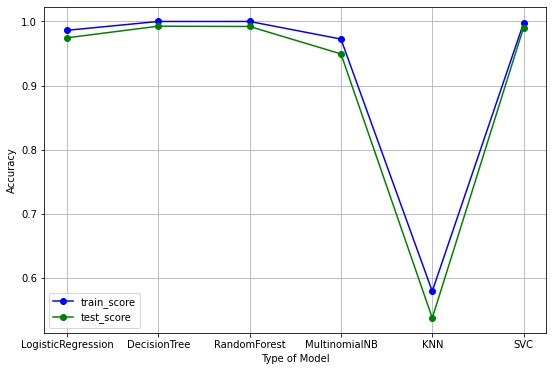

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [107]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('MultinomialNB', MultinomialNB( )))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVC', SVC(kernel='linear')))
seed = 7

# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_stemm_tfidf, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LogisticRegression: 0.978269 (0.002373)
DecisionTreeClassifier: 0.993173 (0.001502)
RandomForestClassifier: 0.993510 (0.001789)
MultinomialNB: 0.952163 (0.006033)
KNN: 0.539712 (0.008979)
SVC: 0.992308 (0.002668)


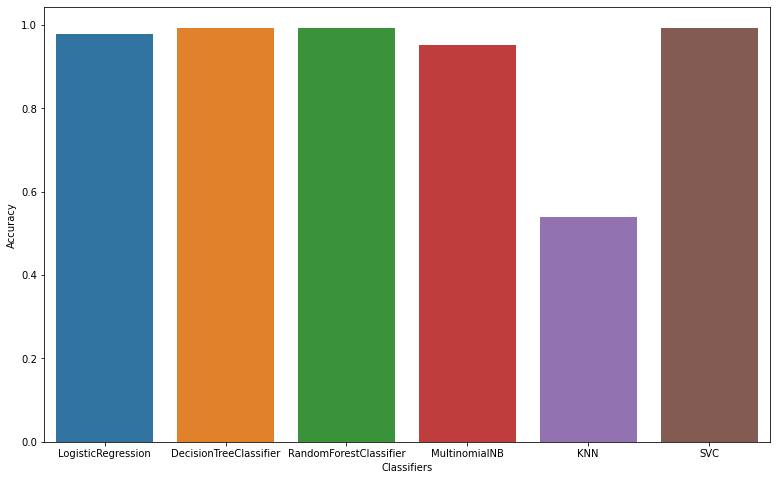

In [108]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Random forest classifier and Decision Tree Classifier**

In [109]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = RandomForestClassifier()


# evaluate model 2
model2 = DecisionTreeClassifier()

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.1680717488124829 t-Statistic: -1.611112051105352
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.


# **TF-IDF VECTORIZER + CHI SQUARE TEST**

In [110]:
X_names2 = tfidf1.get_feature_names()

C:\Users\adity\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [111]:
alpha =.05

In [112]:
from sklearn.feature_selection import chi2
chi2, p = chi2(X_stemm_tfidf, Y)

In [113]:
data2={'features':X_names2,'score':p}
df_features2=pd.DataFrame(data2)

In [114]:
df_features_new2=df_features2[df_features2.score<alpha]
df_features_new2

features     score
5        aaron  0.005685
26      abedin  0.003941
28     abelson  0.016873
41       abort  0.005027
75      access  0.002144
...        ...       ...
17015      yve  0.000966
17058   zernik  0.021022
17089  zionist  0.021849
17102   zraick  0.000034
17112    zuess  0.002411

[1063 rows x 2 columns]

In [115]:
X_names_new2=list(df_features_new2.features.values)


In [116]:
vectorizer2 = TfidfVectorizer(vocabulary=X_names_new2)
vectorizer2.fit(df['stemm_content'].values)
X_stemm_tfidf_chi = vectorizer2.transform(df['stemm_content'].values)    #USEFUL

In [117]:
X_stemm_tfidf_chi

<20800x1063 sparse matrix of type '<class 'numpy.float64'>'
	with 91622 stored elements in Compressed Sparse Row format>

In [118]:
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X_stemm_tfidf_chi, Y, test_size = 0.3)

**Logistic Regression**

In [119]:
log_reg4=LogisticRegression()
log_reg4.fit(X_train4,Y_train4)

Y_lr_train_pred4 =log_reg4.predict(X_train4)
Y_lr_test_pred4 =log_reg4.predict(X_test4)

In [120]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_lr_train_pred4))

print(f"The accuracy score for train data is {accuracy_score(Y_train4,Y_lr_train_pred4)}")
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train4,Y_lr_train_pred4)
print('The classification report is:')
print(classification_report(Y_train4,Y_lr_train_pred4))

the confusion matrix for train data is:
[[7146  117]
 [  80 7217]]
The accuracy score for train data is 0.9864697802197803
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7263
           1       0.98      0.99      0.99      7297

    accuracy                           0.99     14560
   macro avg       0.99      0.99      0.99     14560
weighted avg       0.99      0.99      0.99     14560



In [121]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_lr_test_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_test4,Y_lr_test_pred4)}")
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test4,Y_lr_test_pred4)

print('The classification report is:')
print(classification_report(Y_test4,Y_lr_test_pred4))

the confusion matrix for test data is:
[[3057   67]
 [  33 3083]]
the accuracy score for train data is 0.9839743589743589
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3124
           1       0.98      0.99      0.98      3116

    accuracy                           0.98      6240
   macro avg       0.98      0.98      0.98      6240
weighted avg       0.98      0.98      0.98      6240



**Decision Tree**

In [122]:
my_dt4 = DecisionTreeClassifier()
my_dt4.fit(X_train4,Y_train4)

Y_dt_train_pred4 =my_dt4.predict(X_train4)
Y_dt_test_pred4 =my_dt4.predict(X_test4)

In [123]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_dt_train_pred4))

print(f"The accuracy score for train data is {accuracy_score(Y_train4,Y_dt_train_pred4)}")
dict_train['DecisionTree']=accuracy_score(Y_train4,Y_dt_train_pred4)

print('The classification report is:')
print(classification_report(Y_train4,Y_dt_train_pred4))

the confusion matrix for train data is:
[[7256    7]
 [   4 7293]]
The accuracy score for train data is 0.9992445054945055
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7263
           1       1.00      1.00      1.00      7297

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [124]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_dt_test_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_test4,Y_dt_test_pred4)}")
dict_test['DecisionTree']=accuracy_score(Y_test4,Y_dt_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_dt_test_pred4))

the confusion matrix for test data is:
[[3092   32]
 [  25 3091]]
the accuracy score for train data is 0.9908653846153846
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3124
           1       0.99      0.99      0.99      3116

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Random Forest Classifier**

In [125]:
my_rf4 = RandomForestClassifier()
my_rf4.fit(X_train4,Y_train4)

Y_rf_train_pred4 =my_rf4.predict(X_train4)
Y_rf_test_pred4 =my_rf4.predict(X_test4)

In [126]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_rf_train_pred4))

print(f"The accuracy score for train data is {accuracy_score(Y_train4,Y_rf_train_pred4)}")
dict_train['RandomForest']=accuracy_score(Y_train4,Y_rf_train_pred4)
print('The classification report is:')
print(classification_report(Y_train4,Y_rf_train_pred4))

the confusion matrix for train data is:
[[7255    8]
 [   3 7294]]
The accuracy score for train data is 0.9992445054945055
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7263
           1       1.00      1.00      1.00      7297

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [127]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_rf_test_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_test4,Y_rf_test_pred4)}")
dict_test['RandomForest']=accuracy_score(Y_test4,Y_rf_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_rf_test_pred4))

the confusion matrix for test data is:
[[3095   29]
 [  11 3105]]
the accuracy score for train data is 0.9935897435897436
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3124
           1       0.99      1.00      0.99      3116

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Multinomial Naive Bayes Classifier**

In [128]:
my_nbc4= MultinomialNB()
my_nbc4= my_nbc4.fit(X_train4,Y_train4)

Y_nbc_train_pred4 = my_nbc4.predict(X_train4)
Y_nbc_test_pred4 = my_nbc4.predict(X_test4)

In [129]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_nbc_train_pred4))

print(f"The accuracy score for train data is {accuracy_score(Y_train4,Y_nbc_train_pred4)}")
dict_train['MultinomialNB']=accuracy_score(Y_train4,Y_nbc_train_pred4)
print('The classification report is:')
print(classification_report(Y_train4,Y_nbc_train_pred4))

the confusion matrix for train data is:
[[7214   49]
 [ 559 6738]]
The accuracy score for train data is 0.9582417582417583
The classification report is:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7263
           1       0.99      0.92      0.96      7297

    accuracy                           0.96     14560
   macro avg       0.96      0.96      0.96     14560
weighted avg       0.96      0.96      0.96     14560



In [130]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_nbc_test_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_test4,Y_nbc_test_pred4)}")
dict_test['MultinomialNB']=accuracy_score(Y_test4,Y_nbc_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_nbc_test_pred4))

the confusion matrix for test data is:
[[3107   17]
 [ 224 2892]]
the accuracy score for train data is 0.9613782051282052
The classification report is:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3124
           1       0.99      0.93      0.96      3116

    accuracy                           0.96      6240
   macro avg       0.96      0.96      0.96      6240
weighted avg       0.96      0.96      0.96      6240



**K-Nearest Neighbour**

In [131]:
param_grid_knn4 = {"n_neighbors": [3,5,7,9,11,13,15]}

knn4 = KNeighborsClassifier()

grid_knn4= GridSearchCV(estimator=knn4,param_grid=param_grid_knn4,scoring="accuracy",verbose=1)

grid_knn4 = grid_knn4.fit(X_train4,Y_train4)

print(grid_knn4.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 3}


In [132]:
my_knn4 = KNeighborsClassifier(n_neighbors=3)
my_knn4 = my_knn4.fit(X_train4,Y_train4)

Y_knn_train_pred4 = my_knn4.predict(X_train4)
Y_knn_test_pred4 = my_knn4.predict(X_test4)

In [133]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_knn_train_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_train4,Y_knn_train_pred4)}")
dict_train['KNN']=accuracy_score(Y_train4,Y_knn_train_pred4)
print('The classification report is:')
print(classification_report(Y_train4,Y_knn_train_pred4))

the confusion matrix for train data is:
[[7110  153]
 [ 103 7194]]
the accuracy score for train data is 0.9824175824175824
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7263
           1       0.98      0.99      0.98      7297

    accuracy                           0.98     14560
   macro avg       0.98      0.98      0.98     14560
weighted avg       0.98      0.98      0.98     14560



In [134]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_knn_test_pred4))

print(f"the accuracy score for test data is: {accuracy_score(Y_test4,Y_knn_test_pred4)}")
dict_test['KNN']=accuracy_score(Y_test4,Y_knn_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_knn_test_pred4))

the confusion matrix for test data is:
[[3007  117]
 [  92 3024]]
the accuracy score for test data is: 0.9665064102564103
The classification report is:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3124
           1       0.96      0.97      0.97      3116

    accuracy                           0.97      6240
   macro avg       0.97      0.97      0.97      6240
weighted avg       0.97      0.97      0.97      6240



**SVC**

In [135]:
param_grid_svm4= {"kernel": ['linear','rbf','poly','sigmoid']}

svm4 = SVC()

grid_svm4= GridSearchCV(estimator=svm4,param_grid=param_grid_svm4,scoring="accuracy",verbose=1)

grid_svm4 = grid_svm4.fit(X_train4,Y_train4)

print(grid_svm4.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'rbf'}


In [136]:
my_svm4 = SVC( kernel='rbf')
my_svm4= my_svm4.fit(X_train4,Y_train4)

Y_svm_train_pred4 = my_svm4.predict(X_train4)
Y_svm_test_pred4 = my_svm4.predict(X_test4)

In [137]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_svm_train_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_train4,Y_svm_train_pred4)}")
dict_train['SVC']=accuracy_score(Y_train4,Y_svm_train_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_svm_test_pred4))

the confusion matrix for train data is:
[[7235   28]
 [  15 7282]]
the accuracy score for train data is 0.9970467032967033
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3124
           1       0.99      1.00      0.99      3116

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



In [138]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_svm_test_pred4))

print(f"the accuracy score for test data is: {accuracy_score(Y_test4,Y_svm_test_pred4)}")
dict_test['SVC']=accuracy_score(Y_test4,Y_svm_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_svm_test_pred4))

the confusion matrix for test data is:
[[3096   28]
 [  12 3104]]
the accuracy score for test data is: 0.9935897435897436
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3124
           1       0.99      1.00      0.99      3116

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Plotting accuracy of models**

Text(0, 0.5, 'Accuracy')

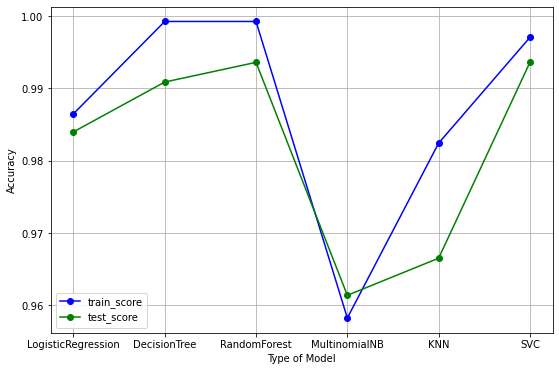

In [139]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [140]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('MultinomialNB', MultinomialNB( )))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVC', SVC(kernel='rbf')))
seed = 7

# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_stemm_tfidf_chi, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LogisticRegression: 0.985913 (0.002720)
DecisionTreeClassifier: 0.990817 (0.001699)
RandomForestClassifier: 0.993462 (0.002338)
MultinomialNB: 0.934375 (0.027794)
KNN: 0.968798 (0.002723)
SVC: 0.992885 (0.002392)


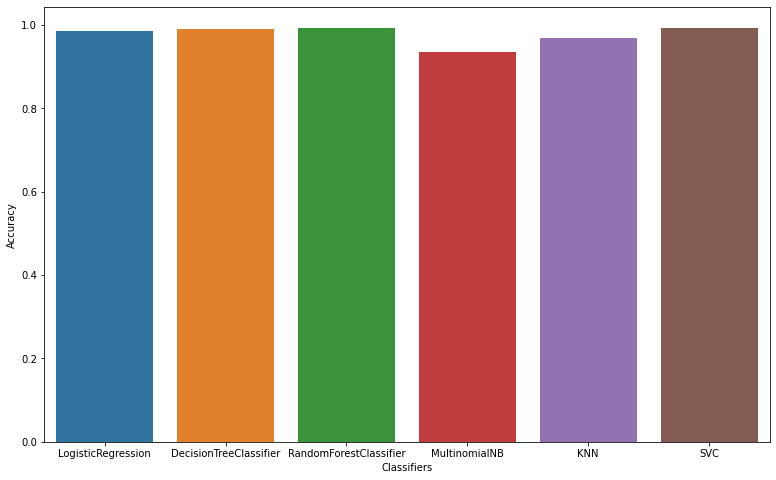

In [141]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Random Forest Classifier and SVC**

In [142]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = RandomForestClassifier()


# evaluate model 2
model2 =  SVC(kernel='rbf')

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.010012884067703991 t-Statistic: 4.030839711561974
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.


# **WORD2VEC**

In [143]:
import gensim

In [144]:
def lemmetize(content):
    document = re.sub('[^a-zA-Z]',' ',str(content))
    document = document.lower()
    document = document.split()
    document = [WordNetLemmatizer().lemmatize(word) for word in document if not word in stopwords.words('english')]
    return document

In [145]:
df['list_lemm_content']=(df['author']+' '+df['title']).apply(lemmetize)
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                       stemm_content  \
0  darrel lucu hous dem aid even see comey letter...   
1  daniel j flynn flynn hillari clinton big woman...   
2             consortiumnew com truth might get fire   
3  jessica purkiss civilian kill singl us airstri...   
4  howard portnoy iranian woman jail fiction unpu...   

                                        lemm_content  \
0  darrell lucus house dem aide even see comey le...   
1  daniel j flynn flynn hillary clinton big woman...   
2           consortiumnews com truth might get fired   
3  jessica purkiss civilian killed single u airst...   
4  howard portnoy iranian woman jailed fictional ...   

                                   list_lemm_content  
0  [darrell, lucus, house, dem, aide, even, see, ...  
1  [daniel, j, flynn, flynn, hillary, clinton, bi...  
2    [consortiumnews, com, truth, might, get, fired]  
3  [jessica, purkiss, civilian, killed, single, u...  
4  [howard, portnoy, iranian, woman, jailed, fict...

In [146]:
w2v_model = gensim.models.Word2Vec(df['list_lemm_content'],vector_size=100,window=50,min_count=1)

In [147]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in df['list_lemm_content']],dtype=object)

In [178]:
X_train_vect

array([array([[-5.6912441e-02,  1.0410961e-01,  1.6478421e-02, ...,
               -8.0493815e-02,  1.1868918e-02,  1.7439241e-02],
              [-5.9350662e-02,  9.6911028e-02,  2.3857012e-02, ...,
               -8.6692162e-02,  1.1188494e-02,  5.9638186e-03],
              [-1.1511968e+00,  2.0812695e+00,  1.3285805e-01, ...,
               -1.2783052e+00,  1.1614748e+00,  1.0481353e-01],
              ...,
              [-4.2594329e-01,  6.8547744e-01,  3.4528926e-01, ...,
               -7.8648967e-01, -1.5677816e-01,  2.6413330e-01],
              [-3.1778000e-02,  4.6295919e-02,  6.9200696e-04, ...,
               -4.2752340e-02,  1.2128389e-02,  1.6757410e-02],
              [-4.9598692e-03,  1.4624940e-02,  5.0446182e-04, ...,
               -8.9284200e-03, -7.9905968e-03, -1.6753292e-03]], dtype=float32),
       array([[-9.26658511e-01,  1.59090114e+00,  2.59508610e-01,
                3.76879461e-02,  5.54865539e-01, -1.17536139e+00,
                1.59261033e-01,  2.99487

In [148]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

In [149]:
X_train_vect_avg

[array([-0.34134504,  0.5954756 ,  0.12637775, -0.00889812,  0.20887785,
        -0.4374864 ,  0.08752751,  1.1914661 , -0.2509673 , -0.15047745,
        -0.22693454, -0.6388682 , -0.15869477,  0.34441313,  0.17092113,
        -0.3622531 ,  0.13074765, -0.54346794,  0.0228904 , -0.8173849 ,
         0.3045642 ,  0.07079136,  0.56868607, -0.01877577, -0.14280461,
        -0.13864966, -0.03190915, -0.13548742, -0.48883322,  0.19982184,
         0.5335087 , -0.01189591, -0.05910674, -0.35572293, -0.04902174,
         0.43149066,  0.0448314 , -0.20883475, -0.30913037, -0.50675565,
         0.35585806, -0.2853548 , -0.10565696,  0.0657516 ,  0.41380796,
        -0.2261604 , -0.6797443 ,  0.07182781,  0.14035493,  0.2447301 ,
         0.23084694, -0.51325375, -0.16842039, -0.07928544, -0.32842407,
         0.04440315,  0.24041814,  0.03946041, -0.31217667,  0.06960008,
        -0.02879638,  0.21204059, -0.02208808, -0.1337079 , -0.7145243 ,
         0.18872719, -0.05538834,  0.16733368, -0.5

In [150]:
X_lemm_w2v = X_train_vect_avg    
#USEFUL

In [182]:
X_lemm_w2v

[array([-0.34134504,  0.5954756 ,  0.12637775, -0.00889812,  0.20887785,
        -0.4374864 ,  0.08752751,  1.1914661 , -0.2509673 , -0.15047745,
        -0.22693454, -0.6388682 , -0.15869477,  0.34441313,  0.17092113,
        -0.3622531 ,  0.13074765, -0.54346794,  0.0228904 , -0.8173849 ,
         0.3045642 ,  0.07079136,  0.56868607, -0.01877577, -0.14280461,
        -0.13864966, -0.03190915, -0.13548742, -0.48883322,  0.19982184,
         0.5335087 , -0.01189591, -0.05910674, -0.35572293, -0.04902174,
         0.43149066,  0.0448314 , -0.20883475, -0.30913037, -0.50675565,
         0.35585806, -0.2853548 , -0.10565696,  0.0657516 ,  0.41380796,
        -0.2261604 , -0.6797443 ,  0.07182781,  0.14035493,  0.2447301 ,
         0.23084694, -0.51325375, -0.16842039, -0.07928544, -0.32842407,
         0.04440315,  0.24041814,  0.03946041, -0.31217667,  0.06960008,
        -0.02879638,  0.21204059, -0.02208808, -0.1337079 , -0.7145243 ,
         0.18872719, -0.05538834,  0.16733368, -0.5

In [152]:
X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X_lemm_w2v, Y, test_size = 0.3)

**Logistic Regression**

In [153]:
log_reg5=LogisticRegression()
log_reg5.fit(X_train5,Y_train5)

Y_lr_train_pred5 =log_reg5.predict(X_train5)
Y_lr_test_pred5 =log_reg5.predict(X_test5)

C:\Users\adity\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [154]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_lr_train_pred5))

print(f"The accuracy score for train data is {accuracy_score(Y_train5,Y_lr_train_pred5)}")
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train5,Y_lr_train_pred5)
print('The classification report is:')
print(classification_report(Y_train5,Y_lr_train_pred5))

the confusion matrix for train data is:
[[6658  717]
 [ 366 6819]]
The accuracy score for train data is 0.9256181318681319
The classification report is:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      7375
           1       0.90      0.95      0.93      7185

    accuracy                           0.93     14560
   macro avg       0.93      0.93      0.93     14560
weighted avg       0.93      0.93      0.93     14560



In [155]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_lr_test_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_test5,Y_lr_test_pred5)}")

print('The classification report is:')
print(classification_report(Y_test5,Y_lr_test_pred5))
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test5,Y_lr_test_pred5)

the confusion matrix for test data is:
[[2722  290]
 [ 173 3055]]
the accuracy score for train data is 0.9258012820512821
The classification report is:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3012
           1       0.91      0.95      0.93      3228

    accuracy                           0.93      6240
   macro avg       0.93      0.93      0.93      6240
weighted avg       0.93      0.93      0.93      6240



**Decision Tree**

In [156]:
my_dt5 = DecisionTreeClassifier()
my_dt5.fit(X_train5,Y_train5)

Y_dt_train_pred5 =my_dt5.predict(X_train5)
Y_dt_test_pred5 =my_dt5.predict(X_test5)

In [157]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_dt_train_pred5))

print(f"The accuracy score for train data is {accuracy_score(Y_train5,Y_dt_train_pred5)}")
dict_train['DecisionTree']=accuracy_score(Y_train5,Y_dt_train_pred5)
print('The classification report is:')
print(classification_report(Y_train5,Y_dt_train_pred5))

the confusion matrix for train data is:
[[7375    0]
 [   0 7185]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7375
           1       1.00      1.00      1.00      7185

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [158]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_dt_test_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_test5,Y_dt_test_pred5)}")
dict_test['DecisionTree']=accuracy_score(Y_test5,Y_dt_test_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_dt_test_pred5))

the confusion matrix for test data is:
[[2778  234]
 [ 296 2932]]
the accuracy score for train data is 0.9150641025641025
The classification report is:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3012
           1       0.93      0.91      0.92      3228

    accuracy                           0.92      6240
   macro avg       0.91      0.92      0.92      6240
weighted avg       0.92      0.92      0.92      6240



**Random Forest Classifier**

In [159]:
my_rf5 = RandomForestClassifier()
my_rf5.fit(X_train5,Y_train5)

Y_rf_train_pred5=my_rf5.predict(X_train5)
Y_rf_test_pred5 =my_rf5.predict(X_test5)

In [160]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_rf_train_pred5))

print(f"The accuracy score for train data is {accuracy_score(Y_train5,Y_rf_train_pred5)}")
dict_train['RandomForest']=accuracy_score(Y_train5,Y_rf_train_pred5)
print('The classification report is:')
print(classification_report(Y_train5,Y_rf_train_pred5))

the confusion matrix for train data is:
[[7375    0]
 [   0 7185]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7375
           1       1.00      1.00      1.00      7185

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [161]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_rf_test_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_test5,Y_rf_test_pred5)}")
dict_test['RandomForest']=accuracy_score(Y_test5,Y_rf_test_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_rf_test_pred5))

the confusion matrix for test data is:
[[2791  221]
 [ 117 3111]]
the accuracy score for train data is 0.9458333333333333
The classification report is:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3012
           1       0.93      0.96      0.95      3228

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240



**K-Nearest Neighbour**

In [162]:
param_grid_knn5 = {"n_neighbors": [3,5,7,9,11,13,15]}

knn5 = KNeighborsClassifier()

grid_knn5= GridSearchCV(estimator=knn5,param_grid=param_grid_knn5,scoring="accuracy",verbose=1)

grid_knn5 = grid_knn5.fit(X_train5,Y_train5)

print(grid_knn5.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 13}


In [163]:
my_knn5 = KNeighborsClassifier(n_neighbors=7)
my_knn5 = my_knn5.fit(X_train5,Y_train5)

Y_knn_train_pred5 = my_knn5.predict(X_train5)
Y_knn_test_pred5 = my_knn5.predict(X_test5)

In [164]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_knn_train_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_train5,Y_knn_train_pred5)}")
dict_train['KNN']=accuracy_score(Y_train5,Y_knn_train_pred5)
print('The classification report is:')
print(classification_report(Y_train5,Y_knn_train_pred5))

the confusion matrix for train data is:
[[6766  609]
 [ 204 6981]]
the accuracy score for train data is 0.9441620879120879
The classification report is:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7375
           1       0.92      0.97      0.94      7185

    accuracy                           0.94     14560
   macro avg       0.95      0.94      0.94     14560
weighted avg       0.95      0.94      0.94     14560



In [165]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_knn_test_pred5))

print(f"the accuracy score for test data is: {accuracy_score(Y_test5,Y_knn_test_pred5)}")
dict_test['KNN']=accuracy_score(Y_test5,Y_knn_test_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_knn_test_pred5))

the confusion matrix for test data is:
[[2737  275]
 [ 122 3106]]
the accuracy score for test data is: 0.9363782051282051
The classification report is:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3012
           1       0.92      0.96      0.94      3228

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



**SVC**

In [166]:
param_grid_svm5= {"kernel": ['linear','rbf','poly','sigmoid']}

svm5 = SVC()

grid_svm5= GridSearchCV(estimator=svm5,param_grid=param_grid_svm5,scoring="accuracy",verbose=1)

grid_svm5 = grid_svm5.fit(X_train5,Y_train5)

print(grid_svm5.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'linear'}


In [167]:
my_svm5 = SVC( kernel='linear')
my_svm5= my_svm5.fit(X_train5,Y_train5)

Y_svm_train_pred5 = my_svm5.predict(X_train5)
Y_svm_test_pred5 = my_svm5.predict(X_test5)

In [168]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_svm_train_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_train5,Y_svm_train_pred5)}")
dict_train['SVC']=accuracy_score(Y_train5,Y_svm_train_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_svm_test_pred5))

the confusion matrix for train data is:
[[6614  761]
 [ 179 7006]]
the accuracy score for train data is 0.9354395604395604
The classification report is:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      3012
           1       0.92      0.98      0.94      3228

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



In [169]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_svm_test_pred5))

print(f"the accuracy score for test data is: {accuracy_score(Y_test5,Y_svm_test_pred5)}")
dict_test['SVC']=accuracy_score(Y_test5,Y_svm_test_pred5)

print('The classification report is:')
print(classification_report(Y_test5,Y_svm_test_pred5))

the confusion matrix for test data is:
[[2721  291]
 [  79 3149]]
the accuracy score for test data is: 0.9407051282051282
The classification report is:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      3012
           1       0.92      0.98      0.94      3228

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



**Gaussian Naive Bayes**

In [170]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf= clf.fit(X_train5,Y_train5)

Y_nbc_train_pred5 = clf.predict(X_train5)
Y_nbc_test_pred5 = clf.predict(X_test5)

In [171]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_nbc_train_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_train5,Y_nbc_train_pred5)}")
dict_train['GaussianNB']=accuracy_score(Y_train5,Y_nbc_train_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_nbc_test_pred5))

the confusion matrix for train data is:
[[4887 2488]
 [ 438 6747]]
the accuracy score for train data is 0.7990384615384616
The classification report is:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      3012
           1       0.76      0.93      0.83      3228

    accuracy                           0.81      6240
   macro avg       0.83      0.80      0.80      6240
weighted avg       0.83      0.81      0.81      6240



In [172]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_nbc_test_pred5))

print(f"the accuracy score for test data is: {accuracy_score(Y_test5,Y_nbc_test_pred5)}")
dict_test['GaussianNB']=accuracy_score(Y_test5,Y_nbc_test_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_nbc_test_pred5))

the confusion matrix for test data is:
[[2038  974]
 [ 218 3010]]
the accuracy score for test data is: 0.808974358974359
The classification report is:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      3012
           1       0.76      0.93      0.83      3228

    accuracy                           0.81      6240
   macro avg       0.83      0.80      0.80      6240
weighted avg       0.83      0.81      0.81      6240



**Plotting accuracy of models**

Text(0, 0.5, 'Accuracy')

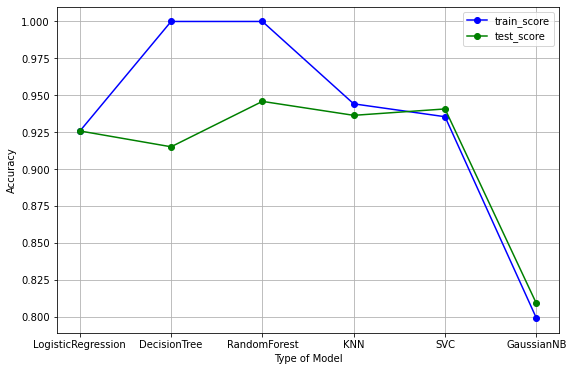

In [173]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [174]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=7)))
models.append(('SVC', SVC(kernel='linear')))
seed = 7

# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_lemm_w2v, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

C:\Users\adity\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\adity\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression: 0.926827 (0.006609)
DecisionTreeClassifier: 0.916106 (0.004838)
RandomForestClassifier: 0.944327 (0.006069)
GaussianNB: 0.803125 (0.007906)
KNN: 0.934183 (0.006594)
SVC: 0.938365 (0.006829)


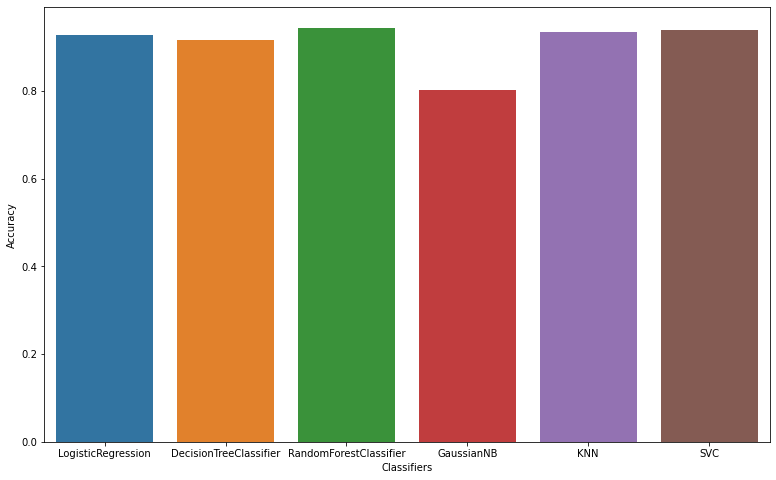

In [175]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Random Forest Classifier and SVC**

In [176]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = RandomForestClassifier()


# evaluate model 2
model2 =  SVC(kernel='linear')

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.08540136452792689 t-Statistic: -2.139222098436774
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.


In [177]:
Y

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)